### Home Task 3

#### Kolesov Alexander

In [78]:
import torch
import torchvision
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1

 Визуализировать матрицы ковариаций для каждого экстремума многоэкстремальной задачи классификации. Визуализацию проводить с помощью интерактивных графиков. Модель: однослойная нейронной сеть. Выборка: произвольная, содержащая несколько экстремумов (допускается использование синтетических выборок). Априорное распределение параметров: нормальное распределение с положительно-определеннной матрицей ковариации (N(0, A^{-1})). Оптимизацию матрицы провести итеративным методом с использованием аппроксимации Лапласа.

### 1. Looking for optimal solutions

Для того чтобы найти экстремумы функции потерь для однослойной полносвязанной линейной нейронной сети, 
нам необходимо запустить данную сеть с различных начальных инициализаций и для каждой из инициализаций 
мы сможем найти какой-то свой экстремум. И на самом деле значения этих экстремумов и будут являться 
$w_{mp}$, то есть решением так называемого Poor Bayesian Inference
$$ \nabla_{w} \log p(w_{mp}) = 0$$


Тогда создаем архитектуру однослойной нейронной сети и обучаем ее на датасете с разных инициализаций, для начала давайте рассмотрим ситуацию, когда находим один какой-то экстремум -  в ситуации с остальными экстремумами аналогична, только начальную инициализацию надо брать другую

In [278]:
net = torch.nn.Linear(32*32*3,10,bias = False).requires_grad_(True)

In [290]:
net.weight.data #initial

tensor([[ 0.0239, -0.0945, -0.1952,  ..., -0.0392, -0.0263, -0.0932],
        [ 0.0272, -0.0301,  0.0592,  ...,  0.0667,  0.0340,  0.0419],
        [-0.0442,  0.0820,  0.0469,  ..., -0.0481, -0.1877, -0.1439],
        ...,
        [ 0.0556, -0.0799,  0.0988,  ..., -0.1308, -0.1962, -0.0425],
        [ 0.1579,  0.0106, -0.0231,  ...,  0.1721,  0.2032,  0.1813],
        [ 0.0134, -0.0696, -0.0765,  ..., -0.0194,  0.1412,  0.1488]])

In [279]:
import torchvision.transforms as transforms

In [291]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

Files already downloaded and verified


In [282]:
import torch.nn as nn

In [292]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [294]:
loss_ = []
for epoch in tqdm.tqdm(range(10)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = inputs.view(-1,3*32*32)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
    loss_.append(running_loss/len(trainloader))
        










  0%|          | 0/10 [00:00<?, ?it/s]








 10%|█         | 1/10 [00:15<02:17, 15.33s/it]








 20%|██        | 2/10 [00:31<02:07, 15.91s/it]








 30%|███       | 3/10 [00:47<01:49, 15.66s/it]








 40%|████      | 4/10 [01:02<01:32, 15.44s/it]








 50%|█████     | 5/10 [01:17<01:17, 15.43s/it]








 60%|██████    | 6/10 [01:33<01:01, 15.48s/it]








 70%|███████   | 7/10 [01:48<00:46, 15.35s/it]








 80%|████████  | 8/10 [02:04<00:31, 15.51s/it]








 90%|█████████ | 9/10 [02:19<00:15, 15.60s/it]








100%|██████████| 10/10 [02:35<00:00, 15.51s/it]


In [62]:
def fill_func_1(f):
    if isinstance(f,torch.nn.Linear):
        f.weight.data.fill_(1.0)

In [63]:
def fill_func_0(f):
    if isinstance(f,torch.nn.Linear):
        f.weight.data.fill_(0.0)

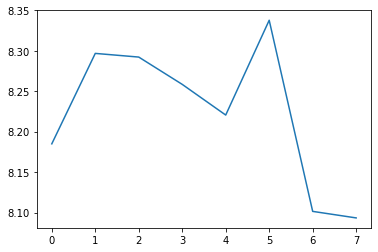

In [296]:
plt.plot(loss_[:8])

Стоит отметить, что однослойной архитектуры не хватает, чтобы уйти в какой-то более благоприятный экстремум - поскольку однослойная архитектура на сифаре как-то не очень заводится

Таким образом, мы получили значение одного из экстремумов и нам надо теперь через аппроксимацию Лапласа , исследовать функцию потерь вблизи этой точки

In [297]:
mp = net.weight
mp

Parameter containing:
tensor([[ 0.1966, -0.5121, -0.9606,  ..., -0.2657, -0.2336, -0.5077],
        [ 0.0019, -0.1213,  0.1475,  ...,  0.6112,  0.1794,  0.3691],
        [-0.0848,  0.3780,  0.1011,  ...,  0.1291, -0.7808, -0.5908],
        ...,
        [ 0.1267, -0.3626,  0.5169,  ..., -0.5452, -0.8958, -0.4554],
        [ 0.6736, -0.0317, -0.3131,  ...,  0.8827,  0.9636,  0.9406],
        [ 0.1967,  0.0439, -0.0287,  ..., -0.2837,  0.8602,  0.7676]],
       requires_grad=True)

### 2. Laplace Approximation 

После того, как мы нашли несколько экстремумов, то в окрестности каждого можно разложить апостериорное распределение в ряд Тейлора в близи такой точки
$$  \log Q(w) \sim \log Q(w_{mp}) + \frac{1}{2}(w - w_{mp})^{T} \nabla \nabla \log Q(w) (w - w_{mp})$$
Где 
$$Q(w) = p(y|x,w)p(w|A)$$

И теперь мы выполняем некоторое исследования функции ошибки вблизи одного из ее экстремумов, а именно оптимизируем веса таким видом, чтобы гэп между честным апостериорным и аппроксимацией Лапласа

Будем теперь то есть подбирать параметры таким образом чтобы уменьшить следующуюу разность и то , что получится в гессиане и будет той самой матрице ковариации , отметим что оптимизация происходит по параметрам модели

$$  \log Q(w) + \log Q(w_{mp}) -  (\frac{1}{2}(w - w_{mp})^{T} \nabla \nabla \log Q(w) (w - w_{mp})) \to \min_{w}$$

Для простоты рассуждений предположи и для прстоты выполнения , что наше априорное распределение это многмерное стандартное нормальное распределение с единичной матрицей ковариации

Теперь создадим функции отвечающие за вычисление вероятности априорной и ту , что вычисляет наша вероятностная модель

In [299]:
def calculate_log_proba(x,y,w):
    net.weight.data = w
    logits = net(x)
    probs = torch.nn.Softmax()(logits)
    return torch.log(probs[y])

In [300]:
def proba_log_prior(w):
    prior = torch.distributions.Normal(loc = 0., scale = 1.)
    log_prob = prior.log_prob(w)
    return log_prob

In [301]:
mp.shape

torch.Size([10, 3072])

Теперь переходим к тому как вычислять Гессиан, для этого мы выпишем с чем имеем дело
$$\nabla \log Q(w) = \nabla \nabla \log p(y|x,w) p(w|A) = \nabla \nabla \log p(y|x,w) + \nabla \nabla p(w|A) $$

Тогда поскольку  $p(y|x,w)$ - это наша вероятностная модель

А двойной дифиринцирование по многомернуму стандартному нормальному распределению даст мне единичную матрицу, потому проиорная вероятность в данном случае простая

In [ ]:
def hessian_Q(w):
     ...
    

In [302]:
mp_ = mp.reshape(30720,1)

In [308]:
import numpy as np

In [1]:
corr = np.corrcoef(mp_.detach().numpy(),mp_.detach().numpy())

NameError: name 'np' is not defined

In [ ]:
import seaborn as sns
%matplotlib inline

sns.heatmap(corr)